<a href="https://colab.research.google.com/github/Makmwa124/Matayo/blob/master/customer_segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this customer segmentation example, we'll analyze the annual spending amounts of 440 clients of a wholesale distributor. 

Spending amounts are provided for the following categories:
1) `Fresh`: annual spending on fresh products (Continuous)
2) `Milk`: annual spending on milk products (Continuous)
3) `Grocery`: annual spending on grocery products (Continuous)
4) `Frozen`: annual spending on frozen products (Continuous)
5) `Detergents_Paper`: annual spending on detergents and paper products (Continuous)
6) `Delicatessen`: annual spending on and deli products (Continuous)

Using this information, we'll attempt to segment the clients into groups of similar clients. 

First, we'll load the dataset and drop the information regarding clients' region and channel. We'll reexamine these columns at the end of this notebook to visually examine our clustering performance. 

In [ ]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs
from pandas.plotting import scatter_matrix

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
except:
    print("Dataset could not be loaded.")

<a id='step0'></a>
## Data Exploration

After loading the data, let's do a little exploration to try and get an idea for what information is in this dataset. 

In [ ]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Selecting Samples

Feel free to select a few examples from the dataset to inspect individually by adding the index to the list below. 

In [ ]:
# Sample a few observations from the dataset
indices = [56, 245, 392]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4098,29892,26866,2616,17740,1340
1,3062,6154,13916,230,8933,2784
2,518,4180,3600,659,122,654


In [ ]:
display(samples - np.round(data.mean()))
display(samples - np.round(data.median()))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-7902.0,24096.0,18915.0,-456.0,14859.0,-185.0
1,-8938.0,358.0,5965.0,-2842.0,6052.0,1259.0
2,-11482.0,-1616.0,-4351.0,-2413.0,-2759.0,-871.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-4406.0,26265.0,22110.0,1090.0,16924.0,374.0
1,-5442.0,2527.0,9160.0,-1296.0,8117.0,1818.0
2,-7986.0,553.0,-1156.0,-867.0,-694.0,-312.0


#### Customer 0
This customer has signficantly higher purchases than average in the categories of milk, grocery, and detergents and paper. This looks like a basic grocery store or convenience store. It's more likely to be a convenience store than a grocery store because it orders less than average amounts of fresh food.

#### Customer 1
This customer has similar purchasing habits to Customer 0 in general, but to a lesser extent. The one differentiating factor is there is a lot more deli purchases than Customer 0. Perhaps this customer is more along the lines of a grocery store.

#### Customer 2
This customer looks like a smaller customer, purchasing less than average in all categories. However, it's spending is closest to the average in the deli category so perhaps this customer is a small cafe.

### Visualize Feature Distributions

To get a better understanding of our features and how they're related, we'll plot a scatter matrix of the six spending categories. Specifically, we're interested in the distribution of values for a given feature (left diagonal) and the correlation between features. 

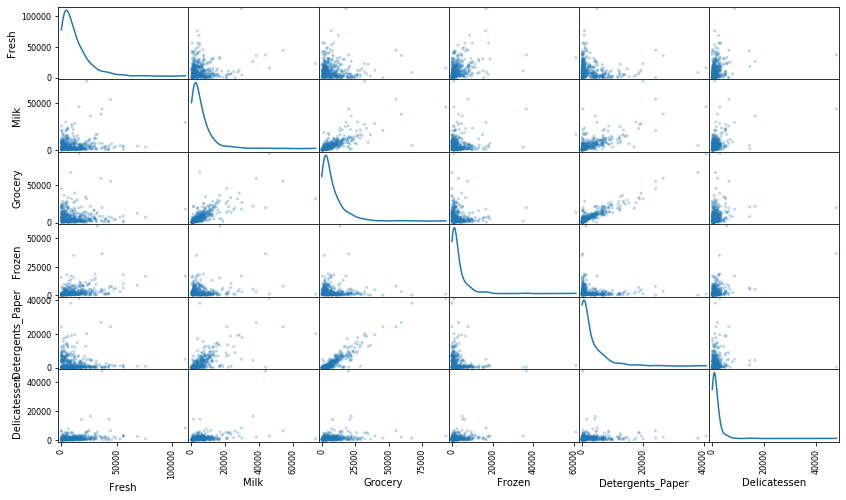

In [ ]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Grocery and detergents_paper seem to have the highest correlation by visual examination of the scatter matrix. I had expected there to be a negative correlation between the fresh and frozen categories - I figured high purchases of fresh foods was not likely to be paired with high spending on frozen foods. This does not appear to be true. 

The data for every category is highly skewed (specifically, right skewed).

<a id='step1'></a>
## Data Preprocessing

Next, we'll scale our features and look for any outliers in our dataset. These preprocessing steps can significantly improve model performance and training time. 

### Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

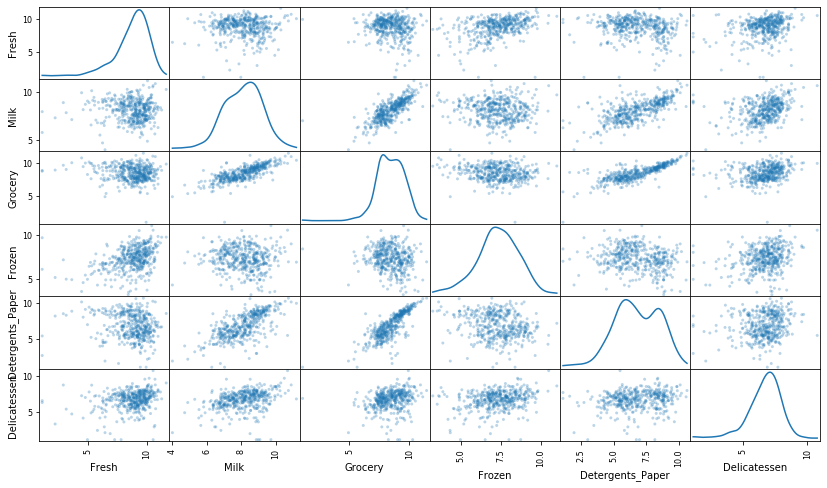

In [ ]:
# Scale the data using the natural logarithm
log_data = data.applymap(np.log)

# Scale the sample data using the natural logarithm
log_samples = samples.applymap(np.log)

# Produce a scatter matrix for each pair of newly-transformed features
scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [ ]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.318254,10.305346,10.198617,7.869402,9.783577,7.200425
1,8.026824,8.724858,9.540795,5.438079,9.097508,7.931644
2,6.249975,8.338067,8.188689,6.490724,4.804021,6.483107


### Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we'll use a simple yet effective method for identifying outliers: An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [ ]:
feature_outliers  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3 - Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    feature_outliers.append(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index)

# Flatten list of outliers from each iteration of the loop above
outliers_flattened = [index for feature in feature_outliers for index in feature]
# Count the number of features for which a given observation is considered an outlier
from collections import Counter
outlier_count = Counter(outliers_flattened)
# Drop observations that are an outlier in 3 or more dimensions of the feature-space
outliers = [observation for observation in outlier_count.elements() if outlier_count[observation] >= 2]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


In [ ]:
# Examine whether or not removing outliers affected the mean or variance in the data
display(log_data.describe())
display(good_data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,8.766671,8.128376,8.460236,7.324601,6.799008,6.694349
std,1.423133,1.062911,1.046108,1.261038,1.684562,1.261066
min,1.098612,4.718499,5.384495,3.218876,1.098612,1.098612
25%,8.073389,7.364809,7.676010,6.647029,5.560615,6.019808
50%,9.055439,8.198089,8.467372,7.340187,6.700731,6.874198
75%,9.737108,8.877379,9.274768,8.177371,8.277644,7.509609
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


In [ ]:
# The following observations are considered outliers for more than one feature based on Tukey's method of outlier detection

display(set([observation for observation in outlier_count.elements() if outlier_count[observation] >= 2]))

print("{} observations were removed from the dataset.".format(
    len(set([observation for observation in outlier_count.elements() if outlier_count[observation] >= 2]))))

{65, 66, 75, 128, 154}

5 observations were removed from the dataset.


According to our outlier detection method, 5 observations had two or more features which were considered an outlier. 

I decided to remove these observations since there was relatively few observations and an outlier in two categories might represent a customer that shouldn't belong in a cluster with the majority of the other data. 

<a id='step2'></a>
## Feature Transformation

In this section we'll use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. A component (dimension) from PCA can be considered a new "feature" of the space.

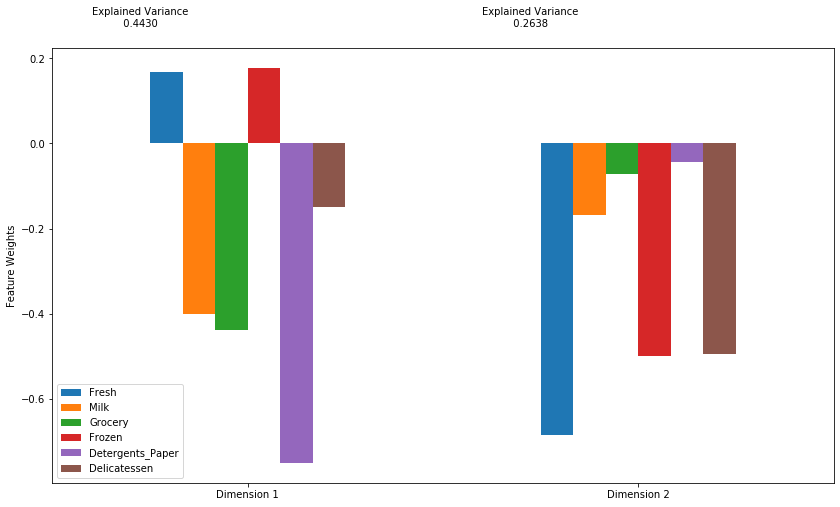

In [ ]:
from sklearn.decomposition import PCA
# Apply PCA by fitting the good data with the same number of dimensions as features
num_features = good_data.shape[1]
pca = PCA(n_components = 2, random_state = 0)
pca = pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

**Interpreting the results:**

Variance explained by first two weights: 0.7234

Variance explained by first four weights: 0.9269

The feature weights may be interpreted as the correlation between the original features and each principal component. What follows is an interpretation of the significance of each feature weight for the first four principal components. Bolded features have a weight greater than +/-0.5.

###### Dimension 1
The first principal component seems to be described primarily by detergents and paper, but also by milk and grocery categories albiet to a lesser degree. Because all of the weights are negative, this suggests that the aforementioned categories vary in a similar manner across the dataset. 

Key features: Milk, grocery, **detergents and paper**. 

###### Dimension 2
The second principal component describes the variance among the three remaining features, fresh, frozen, and deli. These weights, as was the case in the first principal component, all have the same sign signifying they vary together. It is interesting that the first two principal components are both in the opposite direction as the feature vectors which they largely explain, but for the case of dimensionality reduction it does not affect the end results.  

Key features: **Fresh**, frozen, deli. 

### Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In [ ]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2, random_state = 0)
pca = pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [ ]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-3.9321,-0.8289
1,-3.0855,0.5666
2,0.9955,2.3169


<a id='step3'></a>
## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

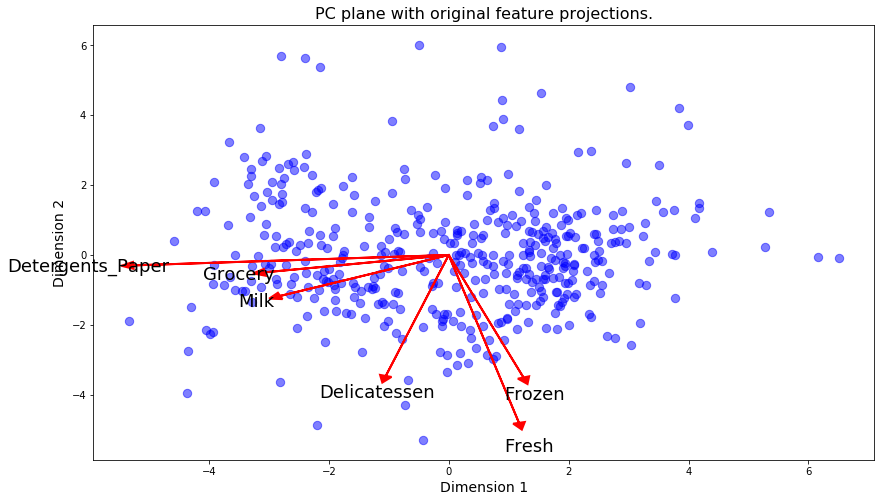

In [ ]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

**Interpreting the biplot:**

The Detergents_Paper vector is most parallel to dimension 1, however, grocery and milk are also fairly parallel to dimension 1. Further, these three vectors point in the opposite direction as dimension 1, as suggested by the feature weights. 

A similar statement could be made about the second dimension with respect to fresh, frozen, and deli. 

<a id='step4'></a>
## Clustering

In this section, we'll implement both K-Means clustering algorithm and Gaussian Mixture Model clustering to segment the wholesale distributor's clients. 

**Advantages and disadvantages of k-means:**

Your understanding of k-means.

**Advantages and disadvantages of Gaussian Mixture Modeling:**

You understanding of GMM.

**Advantages and disadvantages of DBSCAN**:

You understanding of DBSCAN.

**Advantages and disadvantages of AGNES**:

You understanding of AGNES.

### Implementation: Clustering
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

#### K-mean clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Use silhouette score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,10)
kmeans_results = {}
sample_silhouette_values = {}
for size in num_clusters:
    kmeans = KMeans(n_clusters = size).fit(reduced_data)
    preds = kmeans.predict(reduced_data)
    kmeans_results[size] = silhouette_score(reduced_data, preds)
    sample_silhouette_values[size] = silhouette_samples(reduced_data, preds)


best_size = max(kmeans_results, key=kmeans_results.get)

# Build a model with the optimal number of clusters
optimized_kmeans = KMeans(n_clusters = best_size, random_state = 0).fit(reduced_data)
# Assign data to clusters
kmeans_preds = optimized_kmeans.predict(reduced_data)
# Reports the centers of each cluster
kmeans_centers = optimized_kmeans.cluster_centers_
# Store cluster assignment for the three samples we've been manually examining
kmeans_sample_preds = optimized_kmeans.predict(pca_samples)
# Report the best silhouette score 
kmeans_score = silhouette_score(reduced_data, preds)

kmeans_assignment = optimized_kmeans.predict(reduced_data)
sample_kmeans_assignment = optimized_kmeans.predict(pca_samples)

For n_clusters = 2 The average silhouette_score is : 0.42628101546910846
For n_clusters = 3 The average silhouette_score is : 0.39030053879882054
For n_clusters = 4 The average silhouette_score is : 0.33293041968141923
For n_clusters = 5 The average silhouette_score is : 0.352208874352643
For n_clusters = 6 The average silhouette_score is : 0.36458752583307674
For n_clusters = 7 The average silhouette_score is : 0.3648753591099507
For n_clusters = 8 The average silhouette_score is : 0.36437262668066106
For n_clusters = 9 The average silhouette_score is : 0.3590839999080423


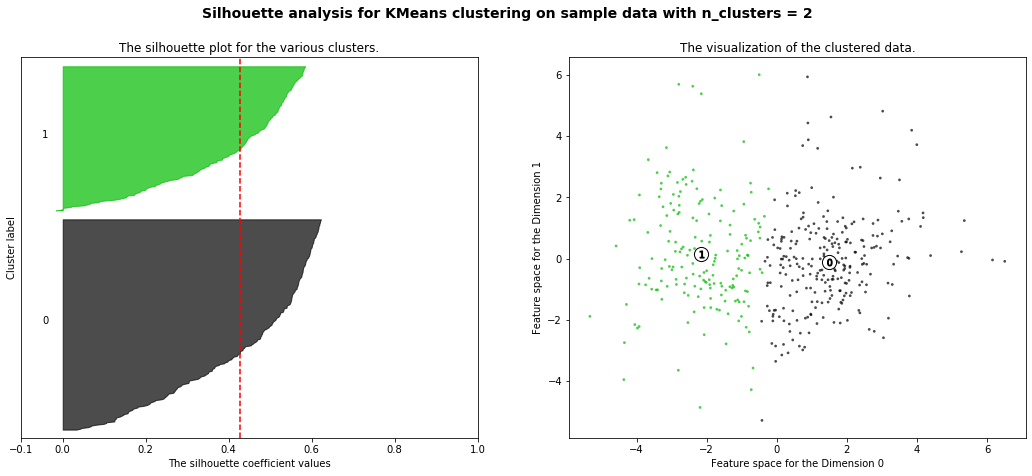

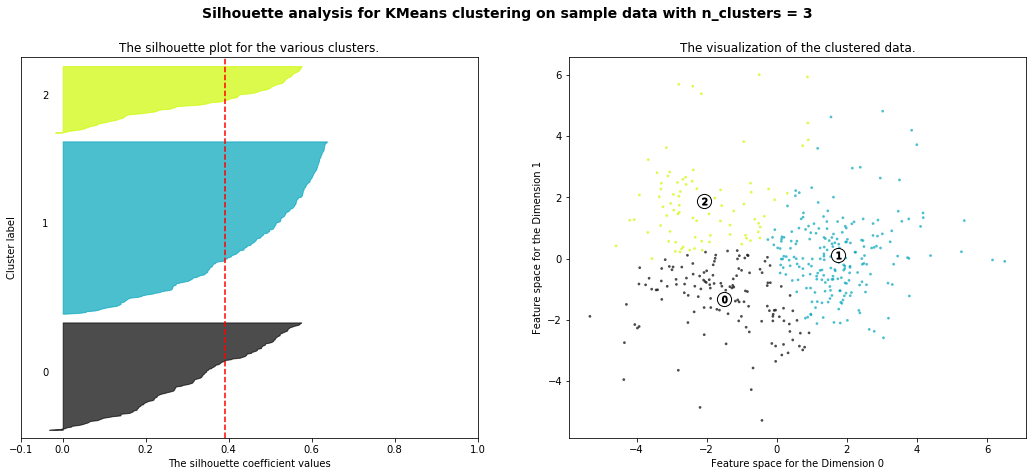

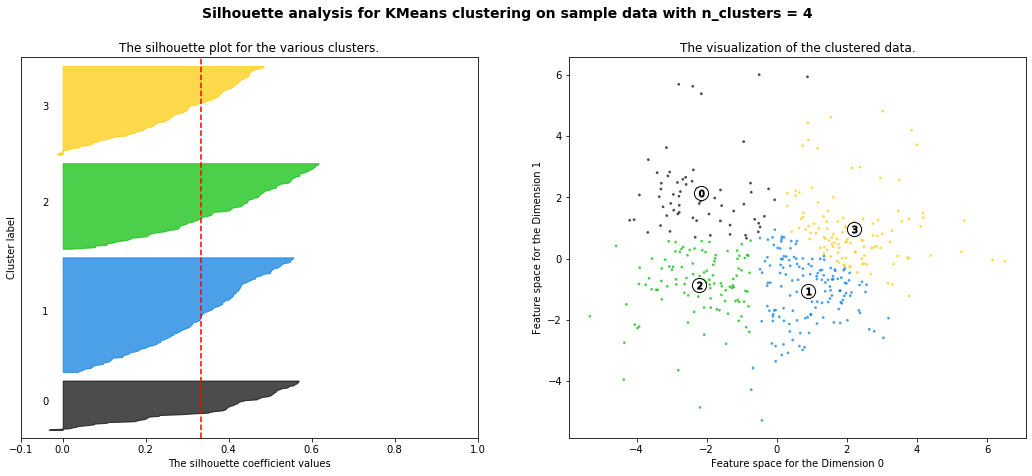

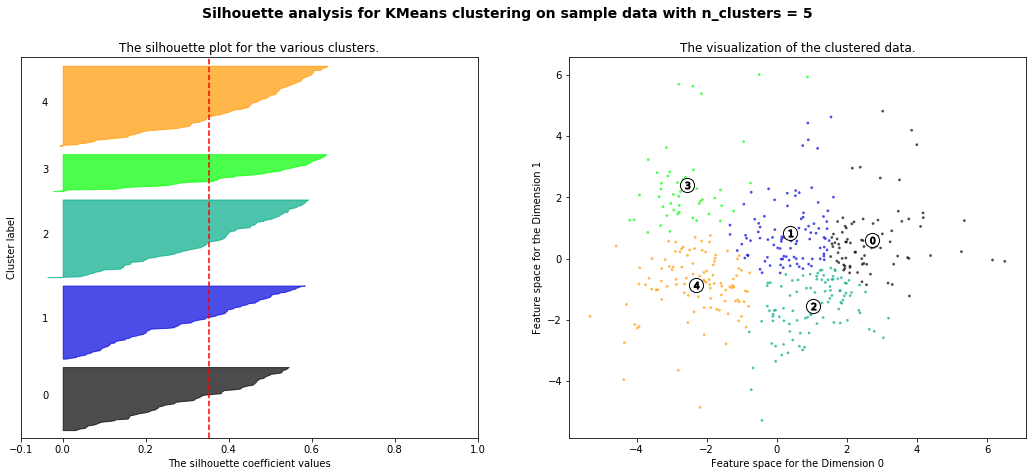

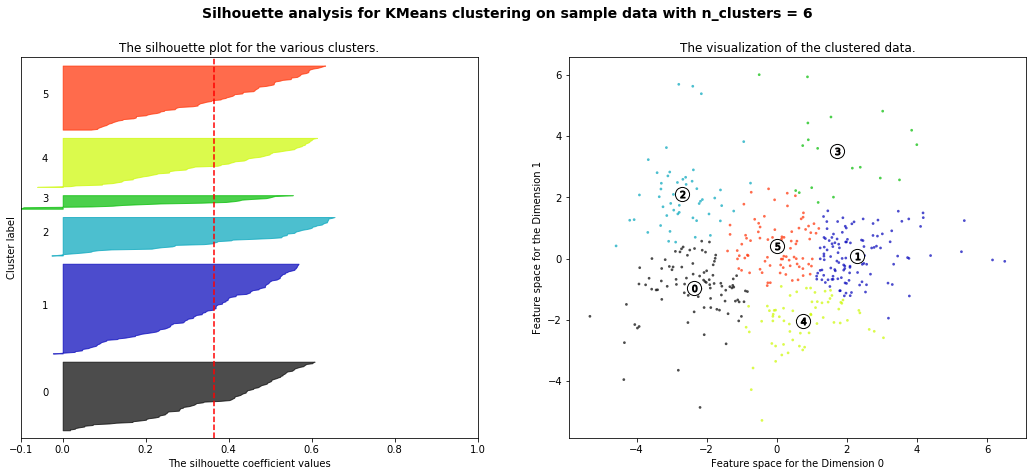

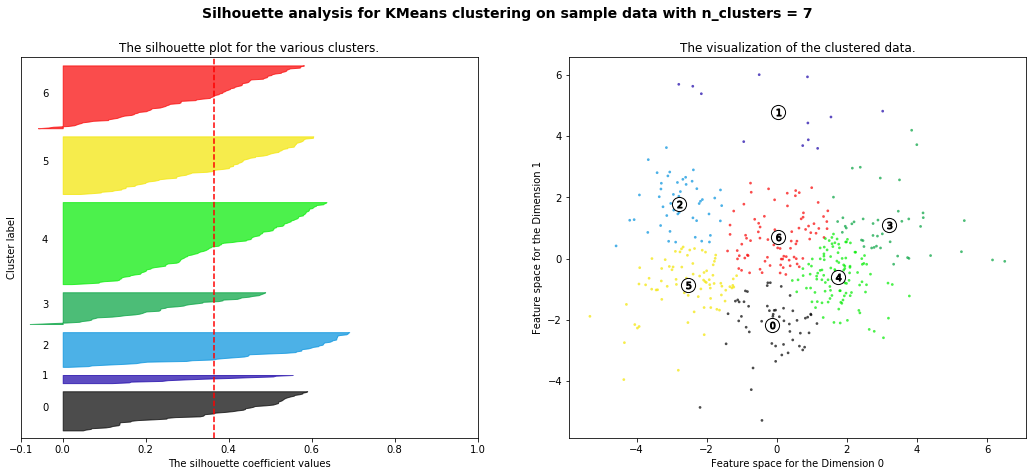

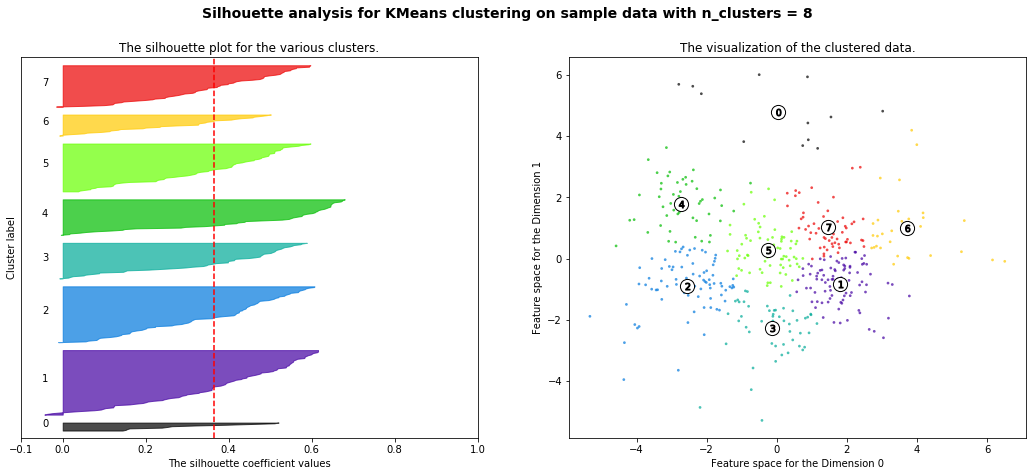

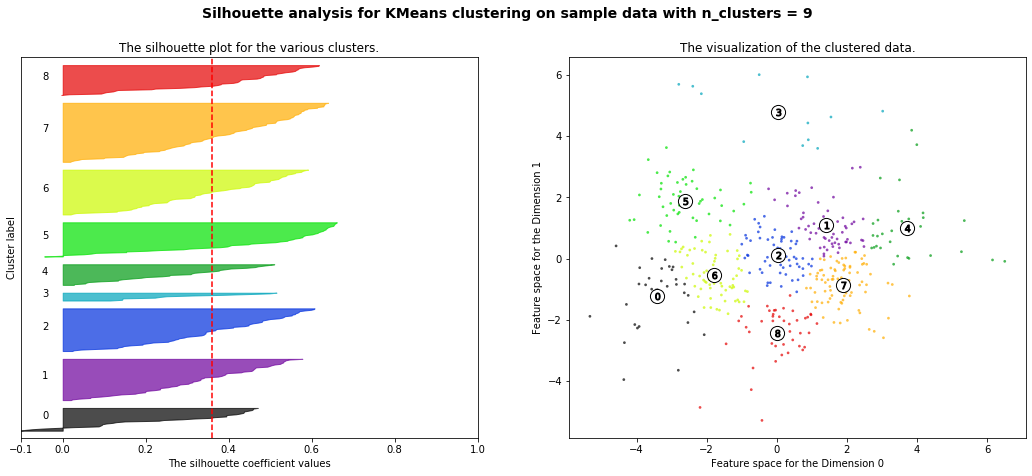

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = num_clusters
X = reduced_data
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the Dimension 0")
    ax2.set_ylabel("Feature space for the Dimension 1")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### Gaussian Mixture Modeling

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Use silhouette score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,10)
gmm_results = {}
for size in num_clusters:
    gmm = GaussianMixture(n_components = size).fit(reduced_data)
    preds = gmm.predict(reduced_data)
    gmm_results[size] = silhouette_score(reduced_data, preds)

best_size = max(gmm_results, key=gmm_results.get)

# Build a model with the optimal number of clusters
optimized_gmm = GaussianMixture(n_components = best_size, random_state = 0).fit(reduced_data)
# Assign data to clusters
gmm_preds = optimized_gmm.predict(reduced_data)
# Reports the centers of each cluster
gmm_centers = optimized_gmm.means_
# Store cluster assignment for the three samples we've been manually examining
gmm_sample_preds = optimized_gmm.predict(pca_samples)
# Report the best silhouette score 
gmm_score = silhouette_score(reduced_data, preds)

gmm_assignment = optimized_gmm.predict_proba(reduced_data)
sample_gmm_assignment = optimized_gmm.predict_proba(pca_samples)

In [ ]:
display(gmm_results)

{2: 0.4219168464626149,
 3: 0.3042099068049292,
 4: 0.29692140475865747,
 5: 0.3125547038629402,
 6: 0.28188952624412295,
 7: 0.32487462883670787,
 8: 0.3029638399764484,
 9: 0.31690008325469116}

It appears that according to the silhouette scores, we should segement our customers into two groups. The scores from both models are in agreement.

### Cluster Visualization

Now, let's visualize our results from clustering by both techniques. 

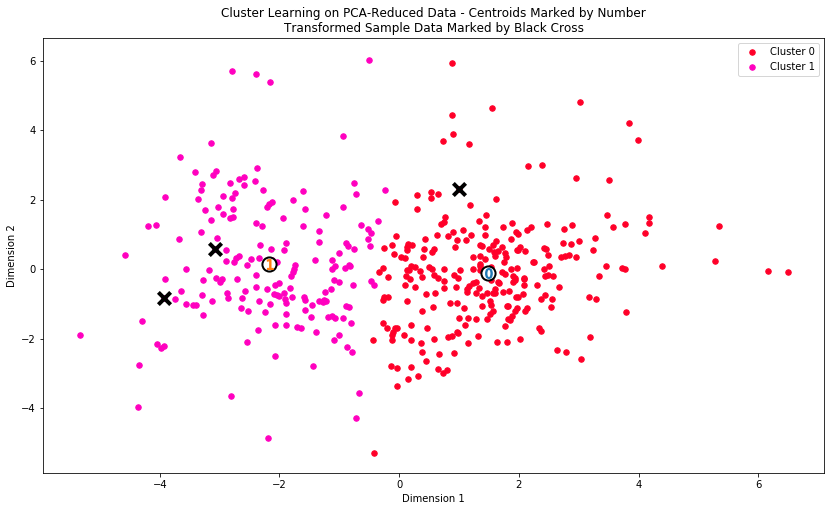

In [ ]:
# Display the results of the clustering from implementation of K-means clustering
vs.cluster_results(reduced_data, kmeans_preds, kmeans_centers, pca_samples)

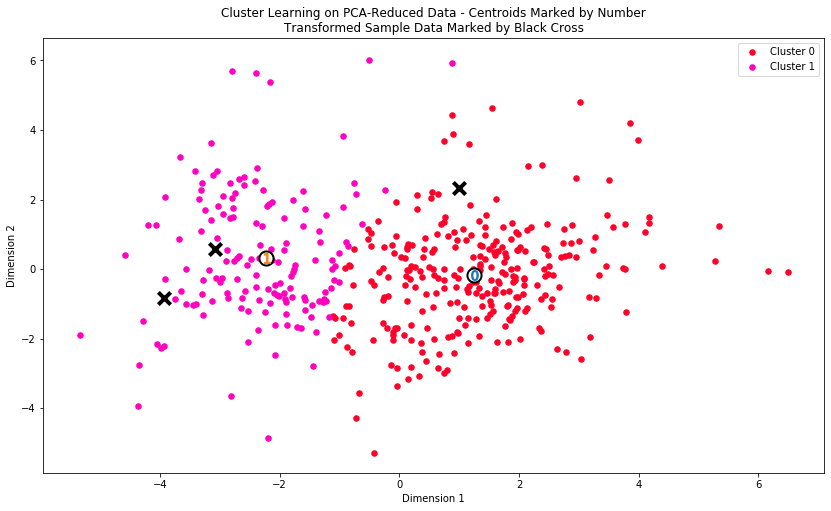

In [ ]:
# Display the results of the clustering from implementation of Gaussian Mixture Model clustering
vs.cluster_results(reduced_data, gmm_preds, gmm_centers, pca_samples)

As you can see, the cluster assignment is largely the same for both techniques. 

We'll use the GMM assignments in the following analysis given the fact that we have access to the probabilities that a given observation belongs to all of the segments. This means that we can observe clients which may exist on the boundary between the two assignments and be equally likely to be assigned to either segment. 

This might be useful if the distributor wishes to change an aspect of their service that would have a strong positive effect for one segment and a strong negative effect for the other segement. To avoid negative effects, the distributor could set a limit and only roll out the new service to clients who have a strong probability of belonging to the segment that would respond positively. 

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [ ]:
# Inverse transform the centers
log_centers = pca.inverse_transform(gmm_centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(gmm_centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

display("Cluster centers compared to average of dataset")
display(true_centers - ikjm   np.round(data.mean()))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


'Cluster centers compared to average of dataset'

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-3047.0,-3682.0,-5186.0,-997.0,-2528.0,-793.0
Segment 1,-8448.0,2041.0,4268.0,-2202.0,1815.0,-563.0


**Analysis:**

Segment 0 has higher than average purchases in the categories of milk, grocery, and detergents and paper. Moreover, this segment seems to make more purchases in general, which suggests it might be largest establishments. These customers are likely retail chains and grocery stores. 

Segment 1, in general, purchases less than Segment 0. This said, a majority of the purchases are in the fresh and grocery categories, which suggest this segment might possibly be restaurants that are preparing and cooking food. 

<a id='step5'></a>
## Visualizing Underlying Distributions

At the beginning of this project, I mentioned that the `'Channel'` and `'Region'` features would be excluded from the dataset. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'Hotel/Restaurant/Cafe'` or `'Retail'` the reduced space.

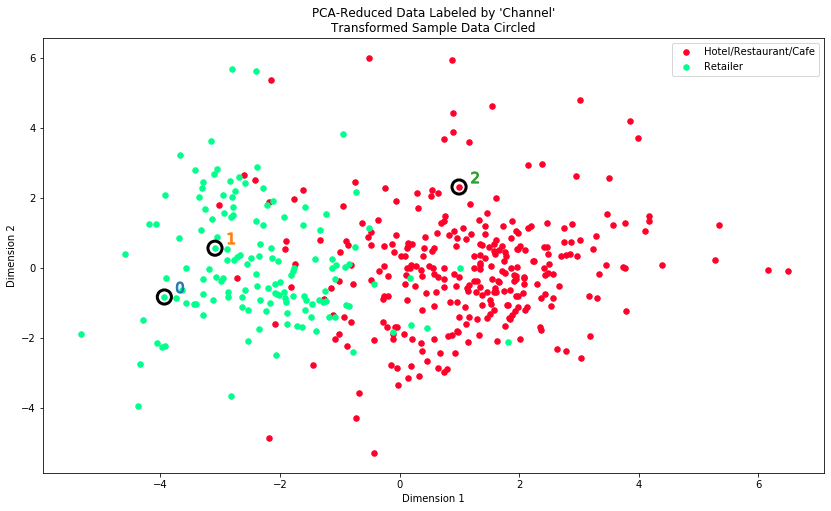

In [ ]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

The silhouette score aided us quite well in choosing the proper number of segments to group the data into. Further, the clustering algorithm generally assigns clients to the proper channel segmentation. The clustering algoritm does make a few mistakes in classifying customers, however, it is likely that increased the number of principal components used in our analysis would allow us to make more accurate predictions. 